# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131

## Витрина данных по участникам Kiev Major

## Финальный файл скрипта: ABT_[DATE].csv

В данном скрипте представлена таблица по командам, которые указаны в файле Dota Features & Snippets - Roles.csv за период с 1 января 2017 года по сегодняшний день. Строка таблицы - информация о матче на уровне игрока. Т.е. если между IG и LGD был матч с match_id = 12345, то таблица содержит 10 записей с данным идентификаторм для каждого конкретного account_id.

In [5]:
%matplotlib notebook
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import requests
from datetime import datetime
import time
from requests.auth import HTTPBasicAuth
import sys
import io
import datetime
import math 
import sklearn 

In [6]:
def download_google_spreadsheet(url):
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        content_bytes = resp.content
    except requests.exceptions.HTTPError as err:
        print(err, file=sys.stderr)
    try:
        content = pd.read_csv(io.BytesIO(content_bytes))
        return content
    except Exception as err:
        print("failed to convert bytes to csv:", err, file=sys.stderr)

In [7]:
def query_opendota(sql):
    resp = requests.get('https://api.opendota.com/api/explorer', params={'sql': sql})
    data = resp.json()
    if resp.status_code == 400 and data is not None:
        sys.stderr.write(data['err'])
    resp.raise_for_status()
    return pd.DataFrame.from_records(data['rows'])

In [8]:
def query_ward_table():
    df_wards = query_opendota('''
    SELECT
    -- Basic table
    matches.match_id,
    player_matches.account_id,
    teams.team_id,
    matches.leagueid,
    leagues.name leaguename,
    matches.start_time,
    player_matches.hero_id,
    player_matches.player_slot,
    ((player_matches.player_slot < 128) = matches.radiant_win) win,
        player_matches.kills,
    player_matches.deaths,
    player_matches.assists,
    player_matches.gold_per_min ,
    player_matches.xp_per_min ,
    player_matches.gold_spent ,
    player_matches.hero_damage ,
    player_matches.tower_damage ,
    player_matches.stuns ,
    player_matches.creeps_stacked ,
    player_matches.camps_stacked ,
    player_matches.hero_healing ,
    player_matches.last_hits,
    player_matches.denies,
    player_matches.level,
    matches.duration,
    matches.cluster,
    matches.first_blood_time,

    --timeStamp variables
    player_matches.gold_t[3] t_Gold_cnt_3,
    player_matches.gold_t[5] t_Gold_cnt_5,
    player_matches.gold_t[8] t_Gold_cnt_8,
    player_matches.gold_t[10] t_Gold_cnt_10,
    player_matches.gold_t[12] t_Gold_cnt_12,
    player_matches.gold_t[15] t_Gold_cnt_15,
    player_matches.gold_t[20] t_Gold_cnt_20,
    player_matches.gold_t[25] t_Gold_cnt_25,
    player_matches.gold_t[30] t_Gold_cnt_30,

    player_matches.lh_t[3] t_LastHits_cnt_3,
    player_matches.lh_t[5] t_LastHits_cnt_5,
    player_matches.lh_t[8] t_LastHits_cnt_8,
    player_matches.lh_t[10] t_LastHits_cnt_10,
    player_matches.lh_t[12] t_LastHits_cnt_12,
    player_matches.lh_t[15] t_LastHits_cnt_15,
    player_matches.lh_t[20] t_LastHits_cnt_20,
    player_matches.lh_t[25] t_LastHits_cnt_25,
    player_matches.lh_t[30] t_LastHits_cnt_30,

    player_matches.xp_t[3] t_Experience_cnt_3,
    player_matches.xp_t[5] t_Experience_cnt_5,
    player_matches.xp_t[8] t_Experience_cnt_8,
    player_matches.xp_t[10] t_Experience_cnt_10,
    player_matches.xp_t[12] t_Experience_cnt_12,
    player_matches.xp_t[15] t_Experience_cnt_15,
    player_matches.xp_t[20] t_Experience_cnt_20,
    player_matches.xp_t[25] t_Experience_cnt_25,
    player_matches.xp_t[30] t_Experience_cnt_30,

    player_matches.pings ping_log,
    player_matches.obs_log,
    player_matches.sen_log,
    player_matches.runes_log,
    player_matches.kills_log,
    player_matches.buyback_log,

    --table_heroStats
    heroes.localized_name,
    heroes.attack_type,
    heroes.primary_attr,
    heroes.roles role_log,

    --purchase_log
    player_matches.purchase_log
FROM matches
JOIN match_patch using(match_id)
JOIN leagues using(leagueid)
JOIN player_matches using(match_id)
JOIN heroes on heroes.id = player_matches.hero_id
LEFT JOIN notable_players ON notable_players.account_id = player_matches.account_id AND notable_players.locked_until = (SELECT MAX(locked_until) FROM notable_players)
LEFT JOIN teams using(team_id)
WHERE TRUE
AND matches.leagueid = 5401 OR matches.leagueid = 4442
AND matches.start_time >= extract(epoch from timestamp '2017-06-30T21:00:00.000Z')
AND teams.team_id IN (5, 15, 39, 46, 2163, 350190, 1375614, 1838315, 1883502, 2108395, 2512249, 2581813, 2586976, 2640025, 2672298, 1333179, 3331948, 1846548)
ORDER BY matches.match_id DESC NULLS LAST
    LIMIT 10000
    '''.format(**locals()))
    return df_wards

# Загружаем данные в формате json, парсим и сохраняем в Pandas

Предварительно ссылку стоит открыть в браузере, иначе она не хочет грузиться (слишком большая?)

In [9]:
matches = query_ward_table()
matches['id'] = matches['match_id'].astype('str') + "_" + matches['account_id'].astype('str')
print(matches.shape)
matches['datetime'] = matches["start_time"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%d.%m.%Y %H:%M:%S'))

(5400, 66)


# Добавляем уникальный идентификатор matchId_accountId и дату

In [10]:
matches['id'] = matches['match_id'].astype('str') + "_" + matches['account_id'].astype('str')
print(matches.shape)
matches['datetime'] = matches["start_time"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%d.%m.%Y %H:%M:%S'))

(5400, 67)


# Список переменных

In [7]:
list(matches)

['account_id',
 'assists',
 'attack_type',
 'buyback_log',
 'camps_stacked',
 'cluster',
 'creeps_stacked',
 'deaths',
 'denies',
 'duration',
 'first_blood_time',
 'gold_per_min',
 'gold_spent',
 'hero_damage',
 'hero_healing',
 'hero_id',
 'kills',
 'kills_log',
 'last_hits',
 'leagueid',
 'leaguename',
 'level',
 'localized_name',
 'match_id',
 'obs_log',
 'ping_log',
 'player_slot',
 'primary_attr',
 'purchase_log',
 'role_log',
 'runes_log',
 'sen_log',
 'start_time',
 'stuns',
 't_experience_cnt_10',
 't_experience_cnt_12',
 't_experience_cnt_15',
 't_experience_cnt_20',
 't_experience_cnt_25',
 't_experience_cnt_3',
 't_experience_cnt_30',
 't_experience_cnt_5',
 't_experience_cnt_8',
 't_gold_cnt_10',
 't_gold_cnt_12',
 't_gold_cnt_15',
 't_gold_cnt_20',
 't_gold_cnt_25',
 't_gold_cnt_3',
 't_gold_cnt_30',
 't_gold_cnt_5',
 't_gold_cnt_8',
 't_lasthits_cnt_10',
 't_lasthits_cnt_12',
 't_lasthits_cnt_15',
 't_lasthits_cnt_20',
 't_lasthits_cnt_25',
 't_lasthits_cnt_3',
 't_lasth

In [33]:
matches.groupby('match_id', as_index=False).last()[['match_id', 'datetime']].tail(48).match_id.tolist()

[3362113115,
 3362175204,
 3362247584,
 3362331228,
 3362390555,
 3362458643,
 3362526195,
 3362609879,
 3362675038,
 3363973439,
 3364084016,
 3364162010,
 3364210383,
 3364267872,
 3364308762,
 3364351128,
 3364409216,
 3364482110,
 3365858882,
 3365946637,
 3366042233,
 3366096005,
 3366166505,
 3366236403,
 3366289447,
 3366363258,
 3366419778,
 3367820228,
 3367897602,
 3367983348,
 3368083254,
 3368158118,
 3368249009,
 3368300783,
 3368387319,
 3369858045,
 3369930606,
 3370054178,
 3370154221,
 3370213472,
 3370307979,
 3370363807,
 3372269708,
 3372386596,
 3372455628,
 3372622939,
 3372676225,
 3372726385]

In [8]:
matches.head()

,account_id,assists,attack_type,buyback_log,camps_stacked,cluster,creeps_stacked,deaths,denies,duration,...,t_lasthits_cnt_3,t_lasthits_cnt_30,t_lasthits_cnt_5,t_lasthits_cnt_8,team_id,tower_damage,win,xp_per_min,id,datetime
0,82327674,8,Ranged,[],1.0,111,5.0,5,0,2719,...,1.0,68.0,2.0,8.0,1375614.0,1765,False,283,3372726385_82327674,13.08.2017 03:12:57
1,149486894,5,Ranged,"[{'time': 2323, 'slot': 1, 'player_slot': 1, '...",2.0,111,4.0,4,12,2719,...,7.0,176.0,19.0,39.0,1375614.0,2864,False,434,3372726385_149486894,13.08.2017 03:12:57
2,139876032,10,Melee,[],1.0,111,1.0,9,0,2719,...,1.0,52.0,2.0,2.0,1375614.0,17,False,337,3372726385_139876032,13.08.2017 03:12:57
3,117281554,8,Ranged,"[{'time': 2543, 'slot': 3, 'player_slot': 3, '...",0.0,111,0.0,3,21,2719,...,4.0,228.0,15.0,40.0,1375614.0,1496,False,696,3372726385_117281554,13.08.2017 03:12:57
4,87012746,12,Melee,[],0.0,111,0.0,6,1,2719,...,3.0,151.0,13.0,27.0,1375614.0,82,False,322,3372726385_87012746,13.08.2017 03:12:57


# Parse Items Timing

In [9]:
t_item = dict()
itemList = [
            'blink',
            'power_treads',
            'ultimate_scepter',
            'phase_boots',
            'travel_boots',
            'blade_mail',
            'arcane_boots',
            'black_king_bar',
            'desolator',
            'magic_wand',
            'tranquil_boots',
            'invis_sword',
            'echo_sabre',
            'manta',
            'ring_of_aquila',
            'force_staff',
            'aether_lens',
            'wind_lace',
            'silver_edge',
            'hand_of_midas',
            'sphere',
            'boots',
            'hurricane_pike',
            'bottle'            
            ]
columnNames = ['id']

for item in itemList:
    columnNames.append("t_item_" + item)

items = pd.DataFrame(columns = columnNames)
    
for i in range(0, len(matches['purchase_log'])):
    
    purchaseList = matches['purchase_log'][i]
    for item in itemList:
        columnName = "t_item_" + item
        t_item[columnName] = np.nan
        
    if not purchaseList is None:
        for purchase in purchaseList:
            for item in itemList:
                columnName = "t_item_" + item
                if purchase['key'] == item and purchase['time'] < 30*60:
                    t_item[columnName] = purchase['time']
                    unique_id = matches['match_id'][i].astype('str') + "_" + matches['account_id'][i].astype('str')
                    t_item['id'] = unique_id
        itemsRow = pd.DataFrame.from_dict(t_item, orient = 'index').transpose()
        items = items.append(itemsRow, ignore_index=True)           
    else: 
        print("Line %s: Log does not exists" %i)

Line 100: Log does not exists
Line 101: Log does not exists
Line 102: Log does not exists
Line 103: Log does not exists
Line 104: Log does not exists
Line 105: Log does not exists
Line 106: Log does not exists
Line 107: Log does not exists
Line 108: Log does not exists
Line 109: Log does not exists
Line 4110: Log does not exists
Line 4111: Log does not exists
Line 4112: Log does not exists
Line 4113: Log does not exists
Line 4114: Log does not exists
Line 4115: Log does not exists
Line 4116: Log does not exists
Line 4117: Log does not exists
Line 4118: Log does not exists
Line 4119: Log does not exists


In [10]:
items.shape

(5380, 25)

In [11]:
matches = matches.merge(items, left_on='id', right_on='id', how='inner')
matches.shape

(5380, 91)

73 записи было удалено из таблицы в связи с отсутствием логов о покупках игроков.

# First Kill Timing (Время в секундах от старта первой пачки крипов)

In [12]:
for i in range(0, len(matches)):
    matches.loc[i, 't_first_kill'] = 0
    try:
        t_first_kill = matches['kills_log'][i][0]['time']
    except Exception:
        print("Line %s: Player has 0 kills" %i)
    if t_first_kill is not None:
        matches.loc[i, 't_first_kill'] = t_first_kill

Line 4: Player has 0 kills
Line 15: Player has 0 kills
Line 24: Player has 0 kills
Line 57: Player has 0 kills
Line 61: Player has 0 kills
Line 67: Player has 0 kills
Line 79: Player has 0 kills
Line 81: Player has 0 kills
Line 102: Player has 0 kills
Line 109: Player has 0 kills
Line 114: Player has 0 kills
Line 115: Player has 0 kills
Line 117: Player has 0 kills
Line 118: Player has 0 kills
Line 143: Player has 0 kills
Line 149: Player has 0 kills
Line 198: Player has 0 kills
Line 213: Player has 0 kills
Line 224: Player has 0 kills
Line 234: Player has 0 kills
Line 251: Player has 0 kills
Line 254: Player has 0 kills
Line 259: Player has 0 kills
Line 284: Player has 0 kills
Line 303: Player has 0 kills
Line 309: Player has 0 kills
Line 335: Player has 0 kills
Line 338: Player has 0 kills
Line 341: Player has 0 kills
Line 352: Player has 0 kills
Line 359: Player has 0 kills
Line 364: Player has 0 kills
Line 403: Player has 0 kills
Line 414: Player has 0 kills
Line 444: Player has 0 

Line 4222: Player has 0 kills
Line 4223: Player has 0 kills
Line 4238: Player has 0 kills
Line 4244: Player has 0 kills
Line 4256: Player has 0 kills
Line 4259: Player has 0 kills
Line 4266: Player has 0 kills
Line 4267: Player has 0 kills
Line 4275: Player has 0 kills
Line 4285: Player has 0 kills
Line 4314: Player has 0 kills
Line 4345: Player has 0 kills
Line 4355: Player has 0 kills
Line 4358: Player has 0 kills
Line 4371: Player has 0 kills
Line 4373: Player has 0 kills
Line 4386: Player has 0 kills
Line 4388: Player has 0 kills
Line 4401: Player has 0 kills
Line 4403: Player has 0 kills
Line 4426: Player has 0 kills
Line 4462: Player has 0 kills
Line 4493: Player has 0 kills
Line 4495: Player has 0 kills
Line 4499: Player has 0 kills
Line 4502: Player has 0 kills
Line 4504: Player has 0 kills
Line 4511: Player has 0 kills
Line 4512: Player has 0 kills
Line 4514: Player has 0 kills
Line 4527: Player has 0 kills
Line 4531: Player has 0 kills
Line 4532: Player has 0 kills
Line 4576:

In [13]:
matches.shape

(5380, 92)

<IPython.core.display.Javascript object>


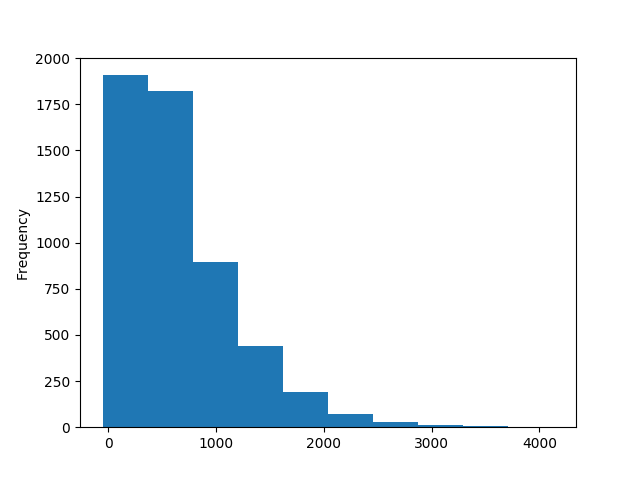

In [14]:
matches['t_first_kill'].plot(kind = 'hist')

# sen_log

In [15]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
sen_cnt = {
                'id':0,
                't_sen_cnt_3':0,
                't_sen_cnt_5':0,
                't_sen_cnt_8':0,
                't_sen_cnt_10':0,
                't_sen_cnt_12':0,
                't_sen_cnt_15':0,
                't_sen_cnt_20':0,
                't_sen_cnt_25':0,
                't_sen_cnt_30':0       
                }

sen = pd.DataFrame(columns = [key for key, value in sen_cnt.items()])

for i in range(0, len(matches['sen_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    sen_cnt = {
                'id':0,
                't_sen_cnt_3':0,
                't_sen_cnt_5':0,
                't_sen_cnt_8':0,
                't_sen_cnt_10':0,
                't_sen_cnt_12':0,
                't_sen_cnt_15':0,
                't_sen_cnt_20':0,
                't_sen_cnt_25':0,
                't_sen_cnt_30':0,
                't_sen_rpm_3':0,
                't_sen_rpm_5':0,
                't_sen_rpm_8':0,
                't_sen_rpm_10':0,
                't_sen_rpm_12':0,
                't_sen_rpm_15':0,
                't_sen_rpm_20':0,
                't_sen_rpm_25':0,
                't_sen_rpm_30':0    
                }
    try: 
        if matches['sen_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['sen_log'][i])):
                for timeStamp in timeStamps:
                    if matches['sen_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_sen_cnt_" + timeStamp
                        varName_rpm = "t_sen_rpm_" + timeStamp
                        sen_cnt[varName_cnt] += 1
                        sen_cnt[varName_rpm] += 1 / float(timeStamp)
            sen_cnt['id'] = matches['id'][i]
            senRow = pd.DataFrame.from_dict(sen_cnt, orient = 'index').transpose()
            sen = sen.append(senRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [16]:
matches = matches.merge(sen, left_on='id', right_on='id', how='inner')
matches.shape

(5380, 110)

# Возникают новые записи в таблице, хотя используется inner join. С чем это может быть связано?

# obs_log

In [17]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
obs_cnt = {
                'id':0,
                't_obs_cnt_3':0,
                't_obs_cnt_5':0,
                't_obs_cnt_8':0,
                't_obs_cnt_10':0,
                't_obs_cnt_12':0,
                't_obs_cnt_15':0,
                't_obs_cnt_20':0,
                't_obs_cnt_25':0,
                't_obs_cnt_30':0       
                }

obs = pd.DataFrame(columns = [key for key, value in obs_cnt.items()])

for i in range(0, len(matches['obs_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    obs_cnt = {
                'id':0,
                't_obs_cnt_3':0,
                't_obs_cnt_5':0,
                't_obs_cnt_8':0,
                't_obs_cnt_10':0,
                't_obs_cnt_12':0,
                't_obs_cnt_15':0,
                't_obs_cnt_20':0,
                't_obs_cnt_25':0,
                't_obs_cnt_30':0,
                't_obs_rpm_3':0,
                't_obs_rpm_5':0,
                't_obs_rpm_8':0,
                't_obs_rpm_10':0,
                't_obs_rpm_12':0,
                't_obs_rpm_15':0,
                't_obs_rpm_20':0,
                't_obs_rpm_25':0,
                't_obs_rpm_30':0    
                }
    try: 
        if matches['obs_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['obs_log'][i])):
                for timeStamp in timeStamps:
                    if matches['obs_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_obs_cnt_" + timeStamp
                        varName_rpm = "t_obs_rpm_" + timeStamp
                        obs_cnt[varName_cnt] += 1
                        obs_cnt[varName_rpm] += 1 / float(timeStamp)
            obs_cnt['id'] = matches['id'][i]
            obsRow = pd.DataFrame.from_dict(obs_cnt, orient = 'index').transpose()
            obs = obs.append(obsRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [18]:
matches = matches.merge(obs, left_on='id', right_on='id', how='inner')
print(matches.shape)

(5380, 128)


# runes_log

In [19]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
runes_cnt = {
                'id':0,
                't_runes_cnt_3':0,
                't_runes_cnt_5':0,
                't_runes_cnt_8':0,
                't_runes_cnt_10':0,
                't_runes_cnt_12':0,
                't_runes_cnt_15':0,
                't_runes_cnt_20':0,
                't_runes_cnt_25':0,
                't_runes_cnt_30':0       
                }

runes = pd.DataFrame(columns = [key for key, value in runes_cnt.items()])

for i in range(0, len(matches['runes_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    runes_cnt = {
                'id':0,
                't_runes_cnt_3':0,
                't_runes_cnt_5':0,
                't_runes_cnt_8':0,
                't_runes_cnt_10':0,
                't_runes_cnt_12':0,
                't_runes_cnt_15':0,
                't_runes_cnt_20':0,
                't_runes_cnt_25':0,
                't_runes_cnt_30':0,
                't_runes_rpm_3':0,
                't_runes_rpm_5':0,
                't_runes_rpm_8':0,
                't_runes_rpm_10':0,
                't_runes_rpm_12':0,
                't_runes_rpm_15':0,
                't_runes_rpm_20':0,
                't_runes_rpm_25':0,
                't_runes_rpm_30':0    
                }
    try:
        if matches['runes_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['runes_log'][i])):
                for timeStamp in timeStamps:
                    if matches['runes_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_runes_cnt_" + timeStamp
                        varName_rpm = "t_runes_rpm_" + timeStamp
                        runes_cnt[varName_cnt] += 1
                        runes_cnt[varName_rpm] += 1 / float(timeStamp)
            runes_cnt['id'] = matches['id'][i]
            runesRow = pd.DataFrame.from_dict(runes_cnt, orient = 'index').transpose()
            runes = runes.append(runesRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [20]:
matches = matches.merge(runes, left_on='id', right_on='id', how='inner')
matches.shape  

(5380, 146)

# buyback_log

In [21]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
buyback_cnt = {
                'id':0,
                't_buyback_cnt_3':0,
                't_buyback_cnt_5':0,
                't_buyback_cnt_8':0,
                't_buyback_cnt_10':0,
                't_buyback_cnt_12':0,
                't_buyback_cnt_15':0,
                't_buyback_cnt_20':0,
                't_buyback_cnt_25':0,
                't_buyback_cnt_30':0       
                }

buyback = pd.DataFrame(columns = [key for key, value in buyback_cnt.items()])

for i in range(0, len(matches['buyback_log'])):
    
    if (i % 1000 == 0):
        print("%s Matches has been processed" %i)
    
    buyback_cnt = {
                'id':0,
                't_buyback_cnt_3':0,
                't_buyback_cnt_5':0,
                't_buyback_cnt_8':0,
                't_buyback_cnt_10':0,
                't_buyback_cnt_12':0,
                't_buyback_cnt_15':0,
                't_buyback_cnt_20':0,
                't_buyback_cnt_25':0,
                't_buyback_cnt_30':0,
                't_buyback_rpm_3':0,
                't_buyback_rpm_5':0,
                't_buyback_rpm_8':0,
                't_buyback_rpm_10':0,
                't_buyback_rpm_12':0,
                't_buyback_rpm_15':0,
                't_buyback_rpm_20':0,
                't_buyback_rpm_25':0,
                't_buyback_rpm_30':0    
                }
    try: 
        if matches['buyback_log'][i] is not None:
            cumulative = 0
            for j in range(0, len(matches['buyback_log'][i])):
                for timeStamp in timeStamps:
                    if matches['buyback_log'][i][j]['time'] < int(timeStamp) * 60:
                        varName_cnt = "t_buyback_cnt_" + timeStamp
                        varName_rpm = "t_buyback_rpm_" + timeStamp
                        buyback_cnt[varName_cnt] += 1
                        buyback_cnt[varName_rpm] += 1 / float(timeStamp)
            buyback_cnt['id'] = matches['id'][i]
            buybackRow = pd.DataFrame.from_dict(buyback_cnt, orient = 'index').transpose()
            buyback = buyback.append(buybackRow, ignore_index=True)
        else: print("Line %s: Log does not exists" %i)
    except Exception:
        print("Line %s: Unknown error" %i)

0 Matches has been processed
1000 Matches has been processed
2000 Matches has been processed
3000 Matches has been processed
4000 Matches has been processed
5000 Matches has been processed


In [22]:
matches = matches.merge(buyback, left_on='id', right_on='id', how='inner')
matches.shape

(5380, 164)

In [23]:
buyback.shape

(5380, 19)

# Hero statistics

In [24]:
urlHeroes = "https://api.opendota.com/api/heroStats"

In [25]:
resp = requests.get('https://api.opendota.com/api/heroStats')
dictData = resp.json()
if resp.status_code == 400 and data is not None:
    sys.stderr.write(data['err'])
resp.raise_for_status()

In [26]:
heroesList = list()
heroAttr = [
            'id',
            'localized_name', 
            'attack_type',
            'pro_ban', 
            'pro_pick', 
            'pro_win', 
            'primary_attr', 
            'roles'
            ]
heroRolesList = [
                'Carry',
                'Disabler',
                'Initiator',
                'Jungler',
                'Support',
                'Durable',
                'Nuker',
                'Escape',
                'Pusher'
                ]

for heroId in range(0, len(dictData) - 1):    
    heroRaw = dict()
    
    for heroRole in heroRolesList:
        heroRaw[heroRole] = 0
    for key, value in dictData[heroId].items():
        if key in heroAttr:
            heroRaw[key] = dictData[heroId][key]
            if key == 'roles':
                for heroRole in dictData[heroId][key]:
                    heroRaw[heroRole] = 1
    del heroRaw['roles']                
    heroesList.append(heroRaw)

In [27]:
heroes = pd.DataFrame(heroesList)
print(heroes.shape)
heroes.head()

(112, 16)


,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support,attack_type,id,localized_name,primary_attr,pro_ban,pro_pick,pro_win
0,1,0,0,1,0,0,1,0,0,Melee,1,Anti-Mage,agi,68.0,38.0,18.0
1,0,1,1,0,1,1,0,0,0,Melee,2,Axe,str,9.0,14.0,8.0
2,0,1,1,0,0,0,1,0,1,Ranged,3,Bane,int,3.0,14.0,8.0
3,1,1,0,0,1,1,1,0,0,Melee,4,Bloodseeker,agi,67.0,44.0,24.0
4,0,1,0,0,0,1,1,0,1,Ranged,5,Crystal Maiden,int,2.0,18.0,7.0


# Возможно косяк здесь, потому что есть по 4 записи на команду, а не 5

In [28]:
matches.groupby(['team_id', 'match_id'], as_index=False).count()

,team_id,match_id,account_id,assists,attack_type,buyback_log,camps_stacked,cluster,creeps_stacked,deaths,...,t_buyback_cnt_8,t_buyback_rpm_10,t_buyback_rpm_12,t_buyback_rpm_15,t_buyback_rpm_20,t_buyback_rpm_25,t_buyback_rpm_3,t_buyback_rpm_30,t_buyback_rpm_5,t_buyback_rpm_8
0,3.0,3275808176,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,3.0,3276098324,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,3.0,3276229201,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,3.0,3276392063,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,3.0,3277831396,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,3.0,3278010775,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
6,3.0,3278177232,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
7,3.0,3278441447,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
8,3.0,3278675143,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
9,3.0,3278898021,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [29]:
matches= matches.merge(heroes, left_on = 'hero_id', right_on = 'id', how = 'inner')
matches.shape

(5367, 180)

# EXP_RPM

In [30]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'experience'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

# GOLD_RPM

In [31]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'gold'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

# LASTHITS_RPM

In [32]:
timeStamps = [
              '3',
              '5',
              '8',
              '10',
              '12',
              '15',
              '20',
              '25',
              '30'
             ]
var = 'lasthits'
varTemplate = 't_' + var + '_'
for timeStamp in timeStamps:
    varName_cnt = varTemplate + 'cnt_' + timeStamp
    varName_rpm = varTemplate + 'rpm_' + timeStamp
    matches[varName_rpm] = matches[varName_cnt] / float(timeStamp)

In [33]:
for col in list(matches):
    print(col)

account_id
assists
attack_type_x
buyback_log
camps_stacked
cluster
creeps_stacked
deaths
denies
duration
first_blood_time
gold_per_min
gold_spent
hero_damage
hero_healing
hero_id
kills
kills_log
last_hits
leagueid
leaguename
level
localized_name_x
match_id
obs_log
ping_log
player_slot
primary_attr_x
purchase_log
role_log
runes_log
sen_log
start_time
stuns
t_experience_cnt_10
t_experience_cnt_12
t_experience_cnt_15
t_experience_cnt_20
t_experience_cnt_25
t_experience_cnt_3
t_experience_cnt_30
t_experience_cnt_5
t_experience_cnt_8
t_gold_cnt_10
t_gold_cnt_12
t_gold_cnt_15
t_gold_cnt_20
t_gold_cnt_25
t_gold_cnt_3
t_gold_cnt_30
t_gold_cnt_5
t_gold_cnt_8
t_lasthits_cnt_10
t_lasthits_cnt_12
t_lasthits_cnt_15
t_lasthits_cnt_20
t_lasthits_cnt_25
t_lasthits_cnt_3
t_lasthits_cnt_30
t_lasthits_cnt_5
t_lasthits_cnt_8
team_id
tower_damage
win
xp_per_min
id_x
datetime
t_item_aether_lens
t_item_arcane_boots
t_item_black_king_bar
t_item_blade_mail
t_item_blink
t_item_boots
t_item_bottle
t_item_desolat

# Заметка: после join появляются id_x и id_y - айдишники правых и левых таблиц

In [34]:
print(matches['id_x'].unique().size)

5367


In [35]:
print(matches['id_y'].unique().size)

111


# Используем id_x в качестве уникального id.
Аналог SQL select distinct id_x from matches (Удаляем дубликаты)

In [36]:
matches.drop_duplicates(subset = 'id_x', inplace = True)

In [37]:
matches.shape

(5367, 207)

In [38]:
matchesWithoutLogs = matches.drop(labels = ['buyback_log', 'kills_log', 'obs_log', 'ping_log', 'purchase_log', 'role_log', 'runes_log', 'sen_log'], axis = 1)

# Добавление ролей игроков

In [39]:
playersRoles = download_google_spreadsheet('https://docs.google.com/spreadsheets/d/e/2PACX-1vRV7SmVCA3a-IgxDRmhEJjFwLner7tEgRXHy_gcgav7GF2pCv4bOlwwt6B8RHkBP8LxV6Idf3zVVnze/pub?output=csv')

In [40]:
playersRoles.head()

,team,player,role,account_id
0,OG,n0tail,1,19672354
1,OG,ana,2,311360822
2,OG,JerAx,4,26771994
3,OG,s4,3,41231571
4,OG,Fly,5,94155156


In [41]:
matchesWithoutLogs = matchesWithoutLogs.merge(playersRoles, left_on = 'account_id', right_on = 'account_id', how = 'left')
matchesWithoutLogs.shape

(5408, 202)

In [42]:
matchesWithoutLogs.drop_duplicates(subset = 'id_x', inplace = True)
matchesWithoutLogs.shape

(5367, 202)

In [47]:
matchesWithoutLogs.to_csv('ABT.csv', na_rep = 'NaN', sep = ';')